#### Nama: Farren Angelica Dinzani
#### NIM: 2702243546
#### Link Video: https://youtu.be/fTdvJNqKeDs?si=Lh_MWrghx57Hn8oa

# IMPORT LIBRARIES

In [22]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU 
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as sk_ssim 

np.random.seed(42)
tf.random.set_seed(42)

# EDA

#### CEK STRUKTUR DATA

In [23]:
# Path ke folder gambar
folder_path = '/kaggle/input/data-a-23/A_23'

# Menampilkan jumlah gambar dan beberapa contoh nama file
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
print(f"Jumlah gambar: {len(image_files)}")
print(f"Beberapa nama file gambar: {image_files[:5]}")

Jumlah gambar: 1074
Beberapa nama file gambar: ['kirmizi (10).jpg', 'kirmizi 97.jpg', 'kirmizi 475.jpg', 'kirmizi 29.jpg', 'kirmizi (20).jpg']


In [24]:
# Memeriksa dimensi gambar secara keseluruhan
image_shapes = []
for file in image_files:
    img = Image.open(os.path.join(folder_path, file))
    image_shapes.append(img.size)

# Menampilkan variasi dimensi gambar
unique_shapes = set(image_shapes)
print(f"Dimensi gambar yang unik: {unique_shapes}")

Dimensi gambar yang unik: {(600, 600)}


- Semua gambar dalam dataset memiliki resolusi yang seragam, yaitu 600x600 piksel.

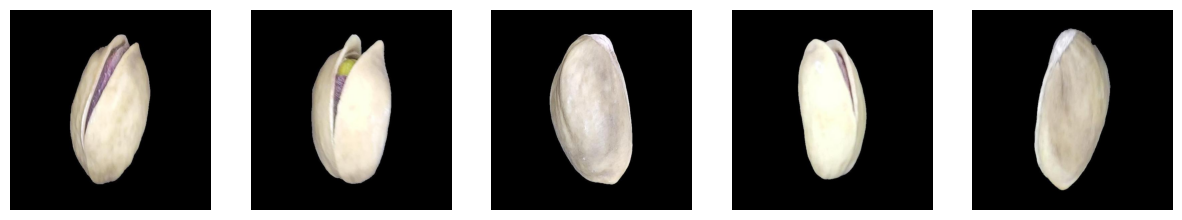

In [25]:
# Menampilkan beberapa contoh gambar
fig, axes = plt.subplots(1, 5, figsize=(15, 10))
for i, ax in enumerate(axes):
    img = Image.open(os.path.join(folder_path, image_files[i]))
    ax.imshow(img)
    ax.axis('off')
plt.show()

- Insight: Gambar berisi objek kerang putih di atas background hitam, seperti yang diharapkan.

- Ini digunakan untuk validasi visual bahwa isi dataset sesuai tujuan proyek dan tidak salah data.

In [26]:
# Memeriksa apakah ada gambar yang tidak bisa dibuka
corrupt_files = []
for file in image_files:
    try:
        img = Image.open(os.path.join(folder_path, file))
        img.verify()  # Memeriksa apakah gambar valid
    except (IOError, SyntaxError):
        corrupt_files.append(file)

print(f"Jumlah gambar rusak: {len(corrupt_files)}")

Jumlah gambar rusak: 0


- Insight: Tidak ditemukan gambar yang rusak.

- Menjamin kualitas data input agar tidak menimbulkan error saat pelatihan model.

#### TAMBAH NOISE GAUSSIAN

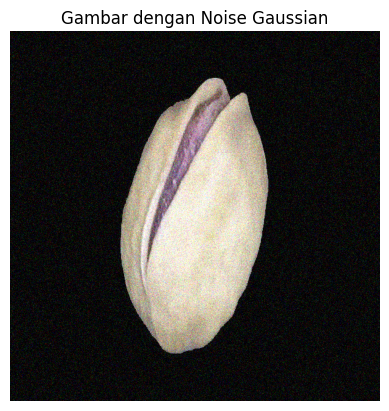

In [ ]:
def add_gaussian_noise(img, mean=0.0, std=0.1, seed=42):
    np.random.seed(seed)
    image_array = np.array(img)
    noise = np.random.normal(mean, std, image_array.shape)
    noisy_image = image_array + noise * 255  # Scaling noise ke dalam range gambar (0-255)
    noisy_image = np.clip(noisy_image, 0, 255)  # Memastikan nilai piksel tetap dalam rentang [0, 255]
    return Image.fromarray(np.uint8(noisy_image))

# Pilih salah satu gambar dari folder dan tambahkan noise
sample_img = Image.open(os.path.join(folder_path, image_files[0]))
noisy_img = add_gaussian_noise(sample_img)
plt.imshow(noisy_img)
plt.axis('off')
plt.title("Gambar dengan Noise Gaussian")
plt.show()

- Insight: Noise berhasil ditambahkan dengan distribusi normal --> mean = 0.0, std = 0.1 (sesuai soal)

- Penambahan noise berguna untuk simulasi kondisi nyata dan melatih model agar lebih robust terhadap noise.

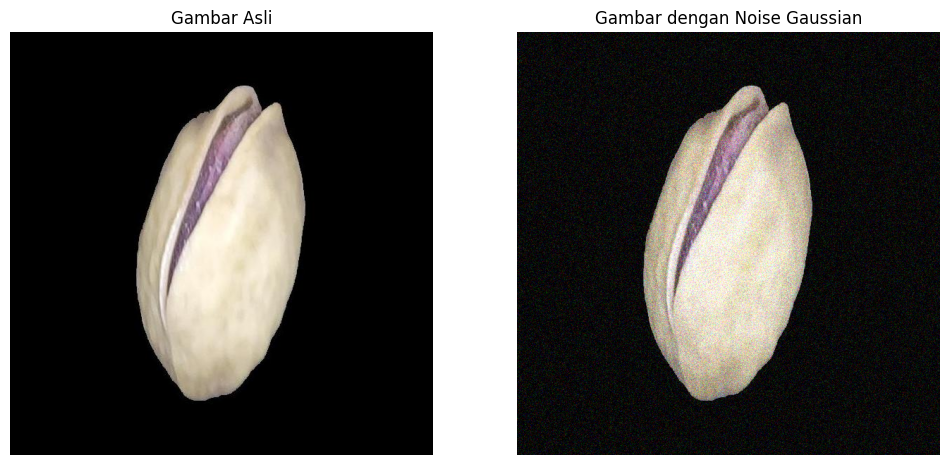

In [28]:
# Visualisasi gambar asli dan gambar yang telah diberi noise
img = Image.open(os.path.join(folder_path, image_files[0]))
img_noisy = add_gaussian_noise(img)
plt.figure(figsize=(12, 6))

# Gambar asli
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Gambar Asli")
plt.axis('off')

# Gambar dengan noise
plt.subplot(1, 2, 2)
plt.imshow(img_noisy)
plt.title("Gambar dengan Noise Gaussian")
plt.axis('off')

plt.show()

- Insight: Perbedaan visual terlihat jelas, noise memperkenalkan gangguan pixel.

- Berguna untuk memahami dampak noise terhadap struktur gambar dan mengevaluasi kemampuan model denoising.

#### PREPROCESSING

In [29]:
# Membaca dan memuat semua gambar ke dalam list
images = []
for file in image_files:
    img_path = os.path.join(folder_path, file)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Pastikan gambar berformat RGB
    images.append(np.array(img))

# Konversi gambar ke array numpy
images = np.array(images)

# Membagi dataset menjadi 80% training, 10% validasi, 10% testing
X_train, X_temp = train_test_split(images, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (859, 600, 600, 3)
X_val shape: (107, 600, 600, 3)
X_test shape: (108, 600, 600, 3)


1. Konversi gambar ke array numpy
    - Insight: Semua gambar disiapkan dalam format array 3D.
    - Ini diperlukan agar bisa diolah oleh model deep learning.

2. Split data: train (80%), val (10%), test (10%)
    - X_train shape: (859, 600, 600, 3)
    - X_val shape: (107, 600, 600, 3)
    - X_test shape: (108, 600, 600, 3)

In [30]:
# Resize semua gambar menjadi 100x100
def resize_images(images, size=(100, 100)):
    resized_images = []
    for img in images:
        resized_img = Image.fromarray(img)
        resized_img = resized_img.resize(size)
        resized_images.append(np.array(resized_img))
    return np.array(resized_images)

# Resize gambar
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)
X_test_resized = resize_images(X_test)

print(f'Resized X_train shape: {X_train_resized.shape}')
print(f'Resized X_val shape: {X_val_resized.shape}')
print(f'Resized X_test shape: {X_test_resized.shape}')


Resized X_train shape: (859, 100, 100, 3)
Resized X_val shape: (107, 100, 100, 3)
Resized X_test shape: (108, 100, 100, 3)


Resize gambar ke ukuran 100x100 (sesuai pada soal)
- Semua gambar berhasil distandarisasi ke dimensi (100, 100, 3)

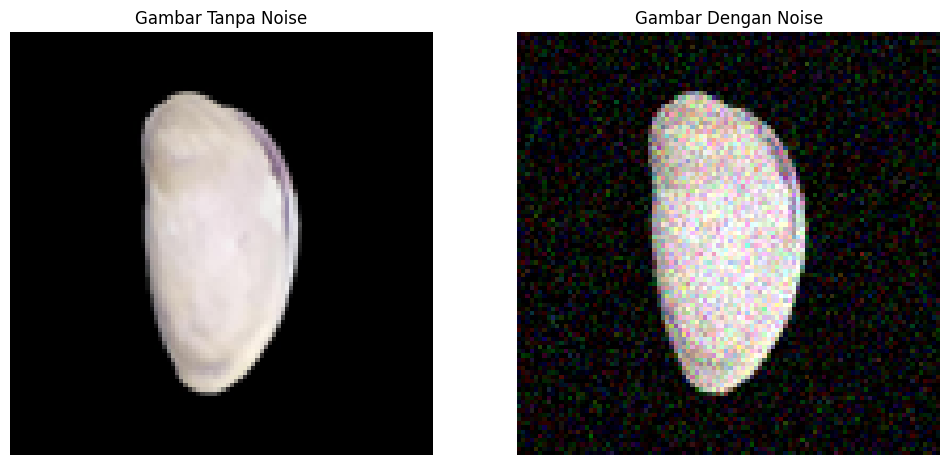

In [31]:
# Menambahkan noise pada data training, validasi, dan testing
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train_resized])
X_val_noisy = np.array([add_gaussian_noise(img) for img in X_val_resized])
X_test_noisy = np.array([add_gaussian_noise(img) for img in X_test_resized])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X_train_resized[0])
plt.title('Gambar Tanpa Noise')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_train_noisy[0])
plt.title('Gambar Dengan Noise')
plt.axis('off')

plt.show()

Penambahan noise pada data split (sesuai pada soal)
- Dataset dengan dan tanpa noise tersedia untuk seluruh subset (train, val, test).
- Memberi peluang melatih model autoencoder untuk image denoising secara konsisten.

# MODEL BASELINE

In [ ]:
# Membuat model Autoencoder sesuai dengan arsitektur yang diberikan di soal
autoencoder_baseline = Sequential()

# Encoder
autoencoder_baseline.add(InputLayer(input_shape=(100, 100, 3)))  # Input layer (Gambar 100x100x3)

autoencoder_baseline.add(Conv2D(32, (3, 3), activation='relu', padding='same'))  # Conv2D layer pertama
autoencoder_baseline.add(MaxPooling2D((2, 2), padding='same'))  # MaxPooling layer pertama

autoencoder_baseline.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # Conv2D layer kedua
autoencoder_baseline.add(MaxPooling2D((2, 2), padding='same'))  # MaxPooling layer kedua

autoencoder_baseline.add(Conv2D(64, (3, 3), activation='relu', padding='same'))  # Conv2D layer ketiga

# Decoder 
autoencoder_baseline.add(UpSampling2D((2, 2)))  # Upsampling layer pertama
autoencoder_baseline.add(Conv2D(32, (3, 3), activation='relu', padding='same'))  # Conv2D layer keempat

autoencoder_baseline.add(UpSampling2D((2, 2)))  # Upsampling layer kedua
autoencoder_baseline.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Conv2D output layer

# Compile model
autoencoder_baseline.compile(optimizer=Adam(), loss='mean_squared_error')

# Ringkasan model
autoencoder_baseline.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Melatih model baseline
history_baseline = autoencoder_baseline.fit(
    X_train_noisy,
    X_train_resized,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_noisy, X_val_resized)
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 9757.9971 - val_loss: 9726.0479
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9744.2598 - val_loss: 9726.0225
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9744.2393 - val_loss: 9726.0098
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9744.2256 - val_loss: 9725.9893
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9744.0391 - val_loss: 9725.5898
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9743.7910 - val_loss: 9725.5576
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9743.7686 - val_loss: 9725.5381
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9743.7539 - val_loss: 9725.5322
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9743.7510 - val_loss: 9725.5303
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9743.7480 - val_loss: 9725.5283
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9743.7461 - val_loss: 9725.5

# MODEL MODIFIKASI

In [ ]:
# Memastikan semua gambar berada dalam rentang [0, 1] dan tipe float
X_train_noisy = X_train_noisy.astype('float32') / 255.0
X_train_resized = X_train_resized.astype('float32') / 255.0
X_val_noisy = X_val_noisy.astype('float32') / 255.0
X_val_resized = X_val_resized.astype('float32') / 255.0
X_test_noisy = X_test_noisy.astype('float32') / 255.0
X_test_resized = X_test_resized.astype('float32') / 255.0

Seluruh data gambar (original dan noisy) dinormalisasi ke rentang [0, 1] dan dikonversi menjadi float agar kompatibel dengan operasi TensorFlow.

In [ ]:
# versi TensorFlow
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_component = ssim_loss(y_true, y_pred)
    return 0.5 * mse + 0.5 * ssim_component

#### MODEL AUTOENCODER MODIFIKASI

Digunakan arsitektur autoencoder yang lebih dalam dan stabil:

- Encoder dengan 3 lapisan Conv2D yang semakin dalam (32 → 64 → 128 filter) disertai dengan BatchNormalization dan Dropout untuk mencegah overfitting.

- Decoder menggunakan UpSampling2D untuk mengembalikan dimensi dan menggabungkan kembali fitur menjadi citra rekonstruksi.

- Aktivasi akhir menggunakan sigmoid agar output tetap dalam [0, 1].

In [ ]:
# Model Autoencoder Modifikasi
autoencoder_mod = Sequential([
    InputLayer(input_shape=(100, 100, 3)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),

    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(3, (3, 3), padding='same', activation='sigmoid')
])

# Compile model --> custom loss
autoencoder_mod.compile(optimizer=Adam(learning_rate=1e-3), loss=combined_loss)
autoencoder_mod.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,651 (733.01 KB)

 Trainable params: 187,011 (730.51 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Train Model Modifikasi
history_mod = autoencoder_mod.fit(
    tf.convert_to_tensor(X_train_noisy, dtype=tf.float32),
    tf.convert_to_tensor(X_train_resized, dtype=tf.float32),
    epochs=50,
    batch_size=64,
    validation_data=(
        tf.convert_to_tensor(X_val_noisy, dtype=tf.float32),
        tf.convert_to_tensor(X_val_resized, dtype=tf.float32)
    )
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0209 - val_loss: 0.0308
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0183 - val_loss: 0.0403
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0170 - val_loss: 0.0345
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0166 - val_loss: 0.0343
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0160 - val_loss: 0.0310
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0158 - val_loss: 0.0304
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0157 - val_loss: 0.0294
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0155 - val_loss: 0.0273
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0153 - val_loss: 0.0245
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0154 - val_loss: 0.0229
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0156 - val_loss: 0.0235
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0

Model dilatih selama 50 epoch dengan batch size 64, menggunakan data gambar yang telah diberi noise sebagai input dan gambar asli sebagai target.

# EVALUASI SSIM MODEL BASELINE & MODIFIKASI

In [44]:
autoencoder_mod.trainable = False

In [45]:
def avg_ssim(model, noisy, clean):
    vals = []
    for i in range(len(noisy)):
        denoised = model.predict(noisy[i:i+1])[0]
        target = clean[i]

        # Pastikan datanya berupa array 2D atau 3D float32
        denoised = denoised.astype(np.float32)
        target = target.astype(np.float32)

        # Hitung SSIM dari skimage
        score = sk_ssim(target, denoised, data_range=1.0, channel_axis=-1)
        vals.append(score)
    return np.mean(vals)

In [46]:
ssim_base = avg_ssim(autoencoder_baseline, X_test_noisy, X_test_resized)
ssim_mod  = avg_ssim(autoencoder_mod,      X_test_noisy, X_test_resized)

print(f"SSIM baseline  : {ssim_base:.4f}")
print(f"SSIM modified  : {ssim_mod :.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

# VISUALISASI HASIL

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


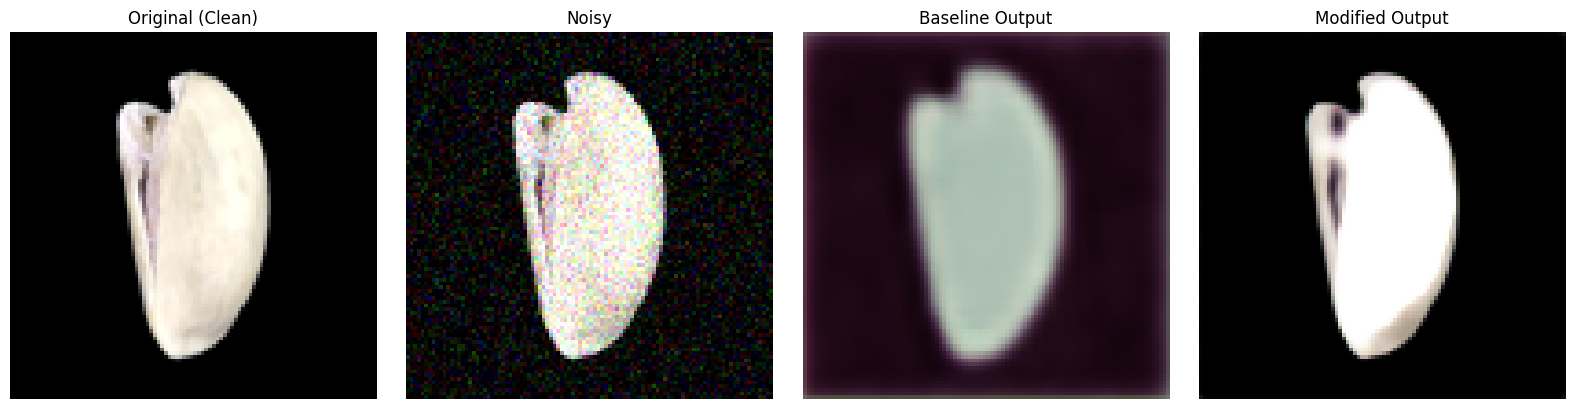

In [ ]:
# indeks gambar uji coba
idx = 0 

original = X_test_resized[idx]
noisy = X_test_noisy[idx]

# Prediksi denoised image
denoised_base = autoencoder_baseline.predict(X_test_noisy[idx:idx+1])[0]
denoised_mod = autoencoder_mod.predict(X_test_noisy[idx:idx+1])[0]

# Plot semua
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

titles = ['Original (Clean)', 'Noisy', 'Baseline Output', 'Modified Output']
images = [original, noisy, denoised_base, denoised_mod]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

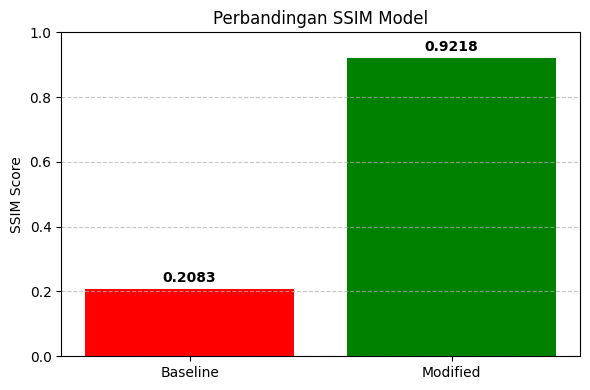

In [ ]:
# Bar chart SSIM
ssim_scores = [ssim_base, ssim_mod]
labels = ['Baseline', 'Modified']
colors = ['red', 'green']

plt.figure(figsize=(6, 4))
plt.bar(labels, ssim_scores, color=colors)
plt.ylim(0, 1)
plt.title('Perbandingan SSIM Model')
plt.ylabel('SSIM Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(ssim_scores):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ANALISA & KESIMPULAN

Evaluasi dilakukan menggunakan metrik SSIM (Structural Similarity Index), yang mengukur kemiripan visual antara gambar hasil denoising dan gambar asli.

Semakin tinggi nilai SSIM (maksimum 1.0), semakin baik kualitas rekonstruksi gambar.

- SSIM baseline  : 0.2083
- SSIM modified  : 0.9218

Analisa:
- Model baseline menghasilkan skor SSIM sebesar 0.2083, yang menandakan bahwa hasil denoising masih jauh dari gambar aslinya dan kurang mampu mempertahankan struktur visual yang penting.

- Model modifikasi yang dilengkapi dengan:

    - Arsitektur autoencoder yang lebih dalam (penambahan Conv2D + BatchNormalization + Dropout),

    - Loss function gabungan (MSE + SSIM),

    - Dan optimasi dengan learning rate yang disesuaikan, mampu menghasilkan skor SSIM sebesar 0.9218.

- Peningkatan ini menunjukkan bahwa model modifikasi dapat merekonstruksi gambar dengan noise secara signifikan lebih akurat dan realistis dibandingkan model baseline.

Kesimpulan:
Modifikasi arsitektur dan loss function terbukti sangat efektif dalam meningkatkan kualitas hasil denoising. Skor SSIM yang tinggi dari model modifikasi menunjukkan bahwa pendekatan ini mampu mempertahankan detail dan struktur penting dalam gambar, sehingga cocok diterapkan untuk tugas pemrosesan citra seperti image denoising pada citra objek dengan noise Gaussian.